## **Module 3 Final Project**

    Title: Northwind Database
    Submitted By: RU KEÏN
    Date: December 5, 2019
    Instructor: James Irving PhD
    https://vimeo.com/rukein/northwind-datascience-project-presentation
    http://www.hakkeray.com/datascience/2019/12/07/thinking-outside-the-lego-box.html

---
## Executive Summary

The goal of this project is to recommend business strategies for increasing sales and saving costs for the Northwind company. This project is based on a fictitious business database created by Microsoft for the use of practicing SQL, hypothesis testing and other data analysis related projects. 

Below are 4 hypotheses (each including a null hypothesis and alternative hypothesis) which I will test for statistical significance to determine if there are any relationships which would be useful from a strategic business perspective. Following this I will summarize the results, make final recommendations, and propose ideas for future analytical work.

---
## Outline

*Statistical Analysis Pipeline*

For each question below, I will follow a standard process of work as outlined here:
- Question
    - Hypotheses
    - Exploratory Data Analysis (EDA)
        - Select dataset
        - Group data
        - Explore data
    - Test 
        - Sample size
        - Normality and Variance
        - Statistical test
        - Effect size (if necessary)
        - Post-hoc tests (if necessary)
    - Analyze Results

---

The statistical testing process is as follows (section 1.4 above):

1. Check if sample sizes allow us to ignore assumptions by visualizing sample size comparisons for two groups (normality check).
    * Bar Plot: SEM (Standard Error of the Mean)

2. If above test fails, check for normality and homogeneity of variance:
    * Test Assumption Normality:
        - D'Agostino-Pearson: scipy.stats.normaltest
        - Shapiro-Wilik Test: scipy.stats.shapiro
    
    * Test for Homogeneity of Variance:
        - Levene's Test: scipy.stats.levene)
Parametric tests (means)	Nonparametric tests (medians)
1-sample t test	1-sample Sign, 1-sample Wilcoxon
2-sample t test	Mann-Whitney tes
One-Way ANOVA	Kruskal-Wallis, Mood’s median tes
Factorial DOE with one factor and one blocking variable	Friedman test
3. Choose appropriate test based on above
    * T Test (1-sample)
         - `stats.ttest_1samp()`
    * T Test (2-sample)
        - stats.ttest_ind()
    * Welch's T-Test (2-sample)
        - stats.ttest_ind(equal_var=False)
    * Mann Whitney U
        - stats.mannwhitneyu()
    * ANOVA
        - stats.f_oneway()
    * Tukey's
        - statsmodels.stats.multicomp.pairwise_tukeyhsd

4. Calculate effect size for significant results.
    * Effect size: 
        - cohen's d

    -Interpretation:
    - Small effect = 0.2 ( cannot be seen by naked eye)
    - Medium effect = 0.5
    - Large Effect = 0.8 (can be seen by naked eye)


5. If significant, follow up with post-hoc tests (if have more than 2 groups)
    * Tukey's

--------------------------
## Table of Contents

- Data Prep

**H1: Discount and Order Quantity**

Does discount amount have a statistically significant effect on order quantity? If so, at what level(s) of discount?

**H2: Countries and Order Quantity: Discount vs Full Price**

Do order quantities of individual countries differ when discounted vs full price?

**H3: Region and Order Revenue**

Does region have a statistically significant effect on average revenue per order?

**H4: Time of Year (Season) and Order Revenue**

Does time of year have a statistically significant effect on average revenue per order?

- Conclusion

- Recommendations

- Future Work
    * A. Product Recommendation Tool
    * B. Free/Discounted Shipping

## Data Prep

In [1]:
# install requisite libraries and packages
!pip install -U fsds_100719 --user
from fsds_100719.imports import *

fsds_1007219  v0.4.45 loaded.  Read the docs: https://fsds.readthedocs.io/en/latest/ 


Handle,Package,Description
dp,IPython.display,Display modules with helpful display and clearing commands.
fs,fsds_100719,Custom data science bootcamp student package
mpl,matplotlib,Matplotlib's base OOP module with formatting artists
plt,matplotlib.pyplot,Matplotlib's matlab-like plotting module
np,numpy,scientific computing with Python
pd,pandas,High performance data structures and tools
sns,seaborn,High-level data visualization library based on matplotlib


In [2]:
from fsds_100719.ds import ihelp, reload
import fsds_100719 as fs

In [3]:
fs.ft.hakkeray.hot_stats()

TypeError: hot_stats() missing 2 required positional arguments: 'data' and 'column'

In [ ]:
# connect to database / import data
import sqlite3 
conn = sqlite3.connect('Northwind_small.sqlite')
cur = conn.cursor()

In [ ]:
# function for converting tables into dataframes on the fly
def get_table(cur, table):
    cur.execute(f"SELECT * from {table};")
    df = pd.DataFrame(cur.fetchall())
    df.columns = [desc[0] for desc in cur.description]
    return df

In [ ]:
# create dataframe of table names for referencing purposes
cur.execute("""SELECT name from sqlite_master WHERE type='table';""")
df_tables = pd.DataFrame(cur.fetchall(), columns=['Table'])
df_tables

In [ ]:
from IPython.display import HTML
HTML('<img src="https://github.com/hakkeray/dsc-mod-3-project-online-ds-ft-100719/blob/master/Northwind_ERD_updated.png?raw=true">')


# H1: Discount--Quantity

* Does discount amount have a statistically significant effect on the quantity of a product in an order? 
* If so, at what level(s) of discount?

## Hypotheses
- $H_0$: Discount amount has no relationship with the quantity of a product in an order.
- $H_A$: Discount amount has a statistically significant effect on the quantity in an order.

- $\alpha$=0.05

## EDA
Select the proper dataset for analysis, perform EDA, and generate data groups for testing.

### Select dataset

In [ ]:
df_orderDetail = get_table(cur, 'OrderDetail')
df_orderDetail.head()

### Group

In [ ]:
# check value counts for each level of discount
df_orderDetail['Discount'].value_counts()

In [ ]:
# insert boolean column showing whether or not an order was discounted
df_orderDetail['discounted'] = np.where(df_orderDetail['Discount'] == 0.0, 0, 1)

# compare number of discount vs fullprice orders
df_orderDetail['discounted'].value_counts()

In [ ]:
# split orders into two groups: discount and fullprice
fullprice = df_orderDetail.groupby('discounted').get_group(0)['Quantity']
discount = df_orderDetail.groupby('discounted').get_group(1)['Quantity']

display(fullprice.head())
display(discount.head())

### Explore

In [ ]:
fullprice.mean()

In [ ]:
discount.mean()

At first glance it looks like the average quantities are indeed higher for discounted orders compared to those that are full price.

In [ ]:
## Examine KDEs
fig, ax = plt.subplots(figsize=(10,6))

group1 = {'name':'fullprice',
         'data':fullprice,
         'n':fullprice.value_counts()}
plot1 = {'hist_kws':dict(color='blue',lw=2, ls='-')}

group2 = {'name':'discount',
         'data':discount,
         'n':discount.value_counts()}
plot2 = {'hist_kws':dict(color='orange',lw=2, ls='-')}


label1= f"{group1['name']} n={group1['n']}"
sns.distplot(group1['data'], label=label1,
             ax=ax, hist_kws=plot1['hist_kws'])
# ax.legend()

label2= f"{group2['name']} n={group2['n']}"
sns.distplot(group2['data'], label=label2,
             ax=ax,hist_kws=plot2['hist_kws'])
# ax.legend()

ax.axvline(group1['data'].mean(),color=plot1['hist_kws']['color'], ls='--')
ax.axvline(group2['data'].mean(),color=plot2['hist_kws']['color'], ls='--')

## Test
**Select the appropriate t-test based on tests for the assumptions of normality and homogeneity of variance.**

### Sample Size
Check if sample sizes allow us to ignore assumptions; if not, test assumption normality.

In [ ]:
# visualize sample size comparisons for two groups (normality check)
import scipy.stats as stat
plt.bar(x='Full Price', height=fullprice.mean(), yerr=stat.sem(fullprice))
plt.bar(x='Discounted', height=discount.mean(), yerr=stat.sem(discount))

### Normality Test
Check assumptions of normality and homogeneity of variance

In [ ]:
# Test for normality - D'Agostino-Pearson's normality test: scipy.stats.normaltest
stat.normaltest(fullprice), stat.normaltest(discount)

Failed normality test (p-values < 0.05). Run non-parametric test:

In [ ]:
# Run non-parametric test (since normality test failed)
stat.mannwhitneyu(fullprice, discount)

### Statistical Test
Perform chosen statistical test.

In [ ]:
# run tukey test for OQD (Order Quantity Discount) 
data = df_orderDetail['Quantity'].values
labels = df_orderDetail['Discount'].values

import statsmodels.api as sms
model = sms.stats.multicomp.pairwise_tukeyhsd(data,labels)

In [ ]:
# save OQD tukey test model results into dataframe (OQD: order quantity discount)
tukey_OQD = pd.DataFrame(data=model._results_table[1:], columns=model._results_table[0])
tukey_OQD

In [ ]:
# Plot a universal confidence interval of each group mean comparing significant differences in group means. 
# Significant differences at the alpha=0.05 level can be identified by intervals that do not overlap 

oq_data = df_orderDetail['Quantity'].values
discount_labels = df_orderDetail['Discount'].values

from statsmodels.stats.multicomp import MultiComparison
oqd = MultiComparison(oq_data, discount_labels)
results = oqd.tukeyhsd()
results.plot_simultaneous(comparison_name=0.25, xlabel='order qty', ylabel='discount level')

### Effect Size
Calculate effect size using Cohen's D as well as any post-hoc tests.

In [ ]:
#### Cohen's d
def Cohen_d(group1, group2):
    # Compute Cohen's d.
    # group1: Series or NumPy array
    # group2: Series or NumPy array
    # returns a floating point number 
    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

In [ ]:
Cohen_d(discount, fullprice)

### Post-hoc Tests

In [ ]:
df_oqd = df_orderDetail.loc[(df_orderDetail['Discount'] >= 0.05) & (df_orderDetail['Discount'] != 0.06) & (df_orderDetail['Discount'] != 0.1)]
df_oqd

In [ ]:
df_oqd['OQD'] = 1
df_oqd

In [ ]:
#df_oqd.groupby(['Discount'])['Quantity'].mean().plot.bar()
plt.bar(x=df_oqd.groupby(['Discount'])['Quantity'].mean(), height=df_oqd.Quantity.mean(), yerr=df_oqd.Discount.sem())

In [ ]:
plt.bar(x='Discounted', height=df_oqd.Quantity.mean(), yerr=df_oqd.Discounted.sem())

In [ ]:
fig = plt.figure(figsize=(8,6))
plt.hist(data=df_oqd, x='Discount', bins=dv, yerr)

In [ ]:
df_orderDetail['OQD'] = df_oqd['OQD']
df_orderDetail['OQD'].fillna(0, inplace=True)
df_orderDetail['OQD'].value_counts()

In [ ]:
# dataframe containing insignificant discount levels
fullprice_df = df_orderDetail.loc[df_orderDetail['OQD'] == 0]
# dataframe containing significant discount levels
discount_df = df_orderDetail.loc[df_orderDetail['OQD'] == 1]

In [ ]:
mean_qty_fp = fullprice_df.Quantity.mean()
mean_qty_dc = discount_df.Quantity.mean()
print(mean_qty_fp, mean_qty_dc)

In [ ]:
diff = mean_qty_dc - mean_qty_fp
diff

In [ ]:
from pandas_profiling import ProfileReport
#ProfileReport(df_oqd)

In [ ]:
sns.distplot(df_orderDetail.Quantity)
sns.distplot(df_oqd.Quantity)

## Analyze Results

The null hypothesis is rejected. Discount amount has a statistically significant effect on the quantity in an order where the discount level is equal to 5%, 15%, 20% or 25%.

NOTES - be more precise (pvalue for test and effect size, therefore rejecting etc)

# H2: Country--Discount

**Do individual countries show a statistically significant preference for discount?**

**If so, which countries and to what extent?** 

## Hypotheses

- $H_0$: Countries purchase equal quantities of discounted vs non-discounted products.
- $H_A$: Countries purchase different quantities of discounted vs non-discounted products.

## EDA
Select the proper dataset for analysis, perform EDA, and generate data groups for testing.

### Select

In [ ]:
df_order = get_table(cur, "'Order'")
display(df_order.head())
display(df_orderDetail.head())

In [ ]:
# Rename 'Id' to 'OrderId' for joining tables with matching primary key name
df_order.rename({'Id':'OrderId'}, axis=1, inplace=True)
display(df_order.head())

### Explore

In [ ]:
df_order.set_index('OrderId',inplace=True)
display(df_order.head())

### Group

In [ ]:
df_countries = df_orderDetail.merge(df_order, on='OrderId', copy=True)
df_countries.head()

In [ ]:
countries = df_countries.groupby('ShipCountry').groups
countries.keys()

In [ ]:
df_countries.loc[df_countries['discounted'] == 1]['ShipCountry'].value_counts()

In [ ]:
df_countries.loc[df_countries['discounted'] == 0]['ShipCountry'].value_counts()

## Test

### Sample Size

In [ ]:
# Check if sample sizes allow us to ignore assumptions;
# visualize sample size comparisons for two groups (normality check)
for k,v in countries.items():
    try:
        grp0 = df_countries.loc[v].groupby('discounted').get_group(0)['Quantity']
        grp1 = df_countries.loc[v].groupby('discounted').get_group(1)['Quantity']
        print(f"{k}")
        import scipy.stats as stat
        plt.bar(x='Full Price', height=grp0.mean(),
               yerr=stat.sem(grp0))
        plt.bar(x='Discounted', height=grp1.mean(),
               yerr=stat.sem(grp1))
        plt.show()
    except:
        print(f"{k} does not contain one of the groups.")

### Normality Test

In [ ]:
sns.distplot(grp0)
sns.distplot(grp1)

In [ ]:
# Test for normality - D'Agostino-Pearson's normality test: scipy.stats.normaltest
stat.normaltest(grp0), stat.normaltest(grp1)

In [ ]:
# Run non-parametric test (since normality test failed)
stat.mannwhitneyu(grp0, grp1)

**Canada, Spain, UK and the USA have pvalues < 0.05 indicating there is a relationship between discount and order quantity and the null hypothesis is rejected for these individual countries.**

In [ ]:
# test normality assumption
for k,v in countries.items():
    try:
        grp0 = df_countries.loc[v].groupby('discounted').get_group(0)['Quantity']
        grp1 = df_countries.loc[v].groupby('discounted').get_group(1)['Quantity']
        result = stat.ttest_ind(grp0,grp1)
        if result[1] < 0.05:
            print(f"\n{k} PREFERS DISCOUNTS!")
        else:
            continue
    except:
        print(f"{k} does not contain one of the groups.")

### Statistical Test

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
model = ols("Quantity~C(discounted)+C(ShipCountry)+C(discounted):C(ShipCountry)", data=df_countries).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

In [ ]:
# reformat scientific notation of results for easier interpretation
anova_table.style.format("{:.5f}", subset=['PR(>F)'])

Although discount does not have a significant effect on countries overall (p = 0.99), there is a statistically significant relationship between order quantities and discount in some of the countries (p=0.0006).

According to the SEM bar plots and ttest statistics above, countries showing a preference for discount include:
* Spain
* UK
* Canada
* USA

### Effect Size

Effect size testing is unnecessary since the null hypothesis for the main question was not rejected.

### Post-hoc Tests

In [ ]:
# Part 2: To what extent (percentage difference) do countries order discount vs full price
discountry_df = df_countries[df_countries.ShipCountry.isin(['Spain','UK','USA','Canada'])]
discountry_df.head()

In [ ]:
#!pip install pandasql
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

In [ ]:
# Plot comparison of discount orders vs fullprice orders for each country where a significant difference exists.
#Spain
q0 = "SELECT ShipCountry, Count(*) from discountry_df where discounted = 0 group by 1;"
q1 = "SELECT ShipCountry, Count(*) from discountry_df where discounted = 1 group by 1;"

fullprice_df = pysqldf(q0)
discount_df = pysqldf(q1)

# Create histograms for each query group
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,8), sharex=True)

ax0 = axes[0]
fullprice_df.set_index('ShipCountry')['Count(*)'].plot(kind='barh', ax=ax0, color='purple')
ax0.set_title('Distribution of Full Price Orders')

ax1 = axes[1]
discount_df.set_index('ShipCountry')['Count(*)'].plot(kind='barh', ax=ax1, color='green')
ax1.set_title('Distribution of Discount Orders')
plt.show()

According to the plot above, the actual number of discounted orders is lower than the number of full price orders. Let's compare the sum of quantities for these orders in each group.

In [ ]:
# Plot comparison of discount orders vs fullprice orders for each country where a significant difference exists.
#Spain
q0 = "SELECT ShipCountry, SUM(Quantity) from discountry_df where discounted = 0 group by 1;"
q1 = "SELECT ShipCountry, SUM(Quantity) from discountry_df where discounted = 1 group by 1;"

fullprice_df = pysqldf(q0)
discount_df = pysqldf(q1)

# Create histograms for each query group
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,8), sharex=True)

ax0 = axes[0]
fullprice_df.set_index('ShipCountry')['SUM(Quantity)'].plot(kind='barh', ax=ax0, color='purple')
ax0.set_title('Distribution of Full Price Quantity')

ax1 = axes[1]
discount_df.set_index('ShipCountry')['SUM(Quantity)'].plot(kind='barh', ax=ax1, color='green')
ax1.set_title('Distribution of Discount Quantity')
plt.show()

This still doesn't tell us much about whether or not these countries prefer discounts (tend to order more products) or not - in order to get better insight, we need to look at the average order size (mean quantities per order) for each group.

In [ ]:
# Plot comparison of discount orders vs fullprice orders for each country where a significant difference exists.
#Spain
q0 = "SELECT ShipCountry, AVG(Quantity) from discountry_df where discounted = 0 group by 1;"
q1 = "SELECT ShipCountry, AVG(Quantity) from discountry_df where discounted = 1 group by 1;"

fullprice_df = pysqldf(q0)
discount_df = pysqldf(q1)

# Create histograms for each query group
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,8), sharex=True)

ax0 = axes[0]
fullprice_df.set_index('ShipCountry')['AVG(Quantity)'].plot(kind='barh', ax=ax0, color='purple')
ax0.set_title('Distribution of Full Price Quantity')

ax1 = axes[1]
discount_df.set_index('ShipCountry')['AVG(Quantity)'].plot(kind='barh', ax=ax1, color='green')
ax1.set_title('Distribution of Discount Quantity')
plt.show()

In [ ]:
# store groups into variables
fp = fullprice_df.set_index('ShipCountry')['AVG(Quantity)']
dc = 

# kwarg dicts


# Create bar plots for fullprice vs discount grouped by country
fig = plot.figure(figsize=(18,8))

sns.plt(kind='barh', data=fp,  
ax0.set_title('Distribution of Full Price Quantity')

ax1 = axes[1]
discount_df.set_index('ShipCountry')['AVG(Quantity)'].plot(kind='barh', ax=ax1, color='green')
ax1.set_title('Distribution of Discount Quantity')
plt.show()

In [ ]:
help(sns.)

The above plots indicate that when a discount is offered, these individual countries do in fact tend to order higher quantities of products. Let's look at the values to determine what percentage more they purchase when an order is discounted.

The graphs show that Western Europe is the region with the greatest number of orders, and also has the greatest total revenue. However, North America has the most expensive order on average (followed by Western Europe). Southern and Eastern Europe has the lowest number of orders, lowest total revenue, and cheapest order on average. The third graph lent support to the alternate hypothesis that there are significant differences in average order revenue between regions. 

In [ ]:
q0 = "SELECT ShipCountry, AVG(Quantity) as fpmean_qty from discountry_df where discounted = 0 group by 1;"
q1 = "SELECT ShipCountry, AVG(Quantity) as dcmean_qty from discountry_df where discounted = 1 group by 1;"
q3 = "SELECT ShipCountry, AVG(Quantity) as mean_qty from discountry_df group by 1;"



fp = pysqldf(q0)
dc = pysqldf(q1)
mean_qty = pysqldf(q3)

country_mean_qty = fp
country_mean_qty['dcmean_qty'] = dc['dcmean_qty']

country_mean_qty['mean_diff'] = country_mean_qty.dcmean_qty - country_mean_qty.fpmean_qty
country_mean_qty['mean_qty'] = mean_qty['mean_qty']

#display(pysqldf(q0), pysqldf(q1))

In [ ]:
country_mean_qty                           

## Results

For certain individual countries (Spain, Canada, UK, USA), the null hypothesis is rejected.

# H3: Region & Revenue

**Does average revenue per order vary between different customer regions?**

**If so, how do the regions rank in terms of average revenue per order?**

## Hypotheses

$H_0$ the average revenue per order is the same between different customer regions.

$H_1$ Alternate hypothesis: the average revenue per order is different (higher or lower) across different customer regions.

*The alpha level (i.e. the probability of rejecting the null hypothesis when it is true) is = 0.05.*

## EDA

Select the proper dataset for analysis, generate data groups for testing, perform EDA.

### Select

In [ ]:
# Extract revenue per product per order
cur.execute("""SELECT c.Region, od.OrderId, od.Quantity, od.UnitPrice, od.Discount
FROM Customer c
JOIN 'Order' o ON c.Id = o.CustomerId
JOIN OrderDetail od USING(OrderId);""")
df = pd.DataFrame(cur.fetchall())
df. columns = [i[0] for i in cur.description]
print(len(df))
df.head()

In [ ]:
# Get total revenue per order

df['Revenue'] = df.Quantity * df.UnitPrice * (1-df.Discount)

In [ ]:
# Drop unnecessary columns
df.drop(['Quantity', 'UnitPrice', 'Discount'], axis=1, inplace=True)

### Group

In [ ]:
# Group data by order and get average revenue per order for each region
df_region = df.groupby(['Region', 'OrderId'])['Revenue'].mean().reset_index()
# drop Order Id (no longer necessary)
df_region.drop('OrderId', axis=1, inplace=True)
# check changes
df_region.head()

In [ ]:
# Explore sample sizes before testing: n > 30 to pass assumptions
df_region.groupby('Region').count()

Some of the sample sizes are too small to ignore assumptions of normality. We can combine some regions to meet the required threshold of n > 30.

In [ ]:
# Group sub-regions together to create sample sizes adequately large for ANOVA testing  (min 30)

# Group Scandinavia, Northern and Eastern Europe
df_region.loc[(df_region.Region == 'Scandinavia') | (df_region.Region == 'Eastern Europe') | (df_region.Region == 'Northern Europe'), 'Region'] = 'North Europe'

# Group South and Central America
df_region.loc[(df_region.Region == 'South America') | (df_region.Region == 'Central America'), 'Region'] = 'South Americas'

# Review sizes of new groups
df_region.groupby('Region').count()

### Explore

In [ ]:
# Plot number of orders, total revenue, and average revenue per order by region
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8,8))
# Number of orders
df_revenue.groupby(['Region'])['order_revenue'].count().plot(kind='barh', ax=ax1)

# Total Revenue
df_revenue.groupby(['Region'])['order_revenue'].sum().plot(kind='barh', ax=ax2)

# Average Revenue
df_revenue.groupby(['Region'])['order_revenue'].mean().plot(kind='barh', ax=ax3)

# Label plots and axes
ax1.set_title('Total Orders')
ax1.set_ylabel('')
ax2.set_title('Total Revenue in US$')
ax2.set_ylabel('')
ax3.set_title('Average Revenue per Order US$')
ax3.set_ylabel('')

fig.subplots_adjust(hspace=0.4);

In [ ]:
table(ax=ax3, data=df_region, rowLabels=None, colLabels=None, **kwargs)

In [ ]:
# Plot number of orders, total revenue, and average revenue per order by region
fig = plt.figure(figsize=(8,8))


#Number of orders
count = df_region.groupby(['Region'])['Revenue'].count()
count.plot(kind='barh', ax=ax1)

# Total Revenue
total = df_revenue.groupby(['Region'])['Revenue'].sum()
total.plot(kind='barh', ax=ax2)

# Average Revenue
mean_rpo = df_revenue.groupby(['Region'])['Revenue'].mean()
mean_rpo.plot(kind='barh', ax=ax3)

# Label plots and axes
ax1.set_title('Total Orders')
ax1.set_ylabel('')
ax2.set_title('Total Revenue in US$')
ax2.set_ylabel('')
ax3.set_title('Average Revenue per Order US$')
ax3.set_ylabel('')

fig.subplots_adjust(hspace=0.4);

In [ ]:

#kind='area','hexbin','kde'
pd.plotting(data=df_region, x='Region', y='mean_rpo', kind='barh', table=True, yerr=None, stacked=True)


## Test

### Sample Size

In [ ]:
# Check if sample sizes allow us to ignore assumptions;
# visualize sample size comparisons 

regions = ['Western Europe', 'Southern Europe', 'Northeastern Europe', 'South Central America', 'North America', 'British Isles']
fig = plt.figure(figsize=(12,6))
for region in regions:
    grp = df_revenue.groupby('Region').get_group(region)['order_revenue']
    plt.bar(x=region, height=grp.mean(), yerr=stat.sem(grp))
    #print(stat.normaltest(grp))
plt.show()

### Normality

### Statistical

In [ ]:
# run tukey test for OQD (Order Quantity Discount) 
data = df_region['Revenue'].values
labels = df_region['Region'].values

import statsmodels.api as sms
model = sms.stats.multicomp.pairwise_tukeyhsd(data,labels)

# save OQD tukey test model results into dataframe (OQD: order quantity discount)
tukey_OQD = pd.DataFrame(data=model._results_table[1:], columns=model._results_table[0])
tukey_OQD

In [ ]:
fig

## Results

At an alpha level of 0.05 significance, revenue does vary between regions and therefore the null hypothesis is rejected.

# H4: Season--Quantity
**Does average quantity per order vary by season / time of year?**

**If so, which months?**

## Hypotheses
    
* $𝐻_1$  : Time of year has a statistically significant effect on average quantity per order.

* $𝐻_0$ : Time of year has no relationship with average quantity per order.

## EDA
Select the proper dataset for analysis, perform EDA, and generate data groups for testing.

       * group by month: determine mean number of orders, mean order quantity 

### Select

In [4]:
df_month = df_orderDetail.merge(df_order, on='OrderId', copy=True)
df_month.head()

NameError: name 'df_orderDetail' is not defined

In [5]:
pd.to_datetime(df_month['OrderDate']).head()

NameError: name 'df_month' is not defined

In [6]:
pd.to_datetime(df_month['OrderDate'], format='%Y/%m/%d').head()

NameError: name 'df_month' is not defined

In [7]:
df_month['OrderMonth'] = pd.DatetimeIndex(df_month['OrderDate']).month
df_month['OrderYear'] = pd.DatetimeIndex(df_month['OrderDate']).year
df_month.head()

NameError: name 'df_month' is not defined

### Group

In [8]:
mqpo_m = df_month.groupby('OrderMonth')['Quantity'].mean()

NameError: name 'df_month' is not defined

In [9]:
# plot average order quantities by month
for k,v in mqpo_m.items():
    plt.bar(x=k, height=v, yerr=)

SyntaxError: invalid syntax (<ipython-input-9-3d614feb435c>, line 3)

### Group

In [10]:
# create seasonal-based dataframe with only columns we need
#keep_cols = ['OrderId', 'ProductId', 'UnitPrice', 'Quantity', 'ShipCountry', 'OrderMonth', 'OrderYear', 'Season']
drop_cols = ['Id', 'discounted', 'OQD', 'CustomerId', 'EmployeeId', 'Freight', 'OrderDate', 'RequiredDate', 'ShippedDate', 'ShipVia', 'ShipName', 'ShipAddress', 'ShipCity', 'ShipRegion', 'ShipPostalCode']
df_month.drop(drop_cols, axis=1, inplace=True)
df_month.head()

NameError: name 'df_month' is not defined

In [ ]:
# Add another feature to examine: revenue
df_month['Revenue'] = df_month.UnitPrice * df_month.Quantity * (1 - df_month.Discount)
df_month.Revenue.mean()

## Test

### Sample Size

In [549]:
# group by seasons
# Check if sample sizes allow us to ignore assumptions;
# visualize sample size comparisons for two groups (normality check)


In [ ]:
# Anova Test - Season + Quantity ()

import statsmodels.api as sm
from statsmodels.formula.api import ols

f = 'Quantity ~ C(OrderMonth)'
lm = ols(formula, df_month).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)



# Compares two sets of data, which are both approximately normally distributed.
# The null hypothesis, in this case, is that the two distributions have the same mean.
# It takes the two distributions as inputs and returns the t-statistic and a p-value.

f = ' ~ C(supp) + C(dose)'
lm = ols(formula, df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

In [557]:
# Create keywords for .set_xticklabels()
tick_kwds = dict(horizontalalignment='right', 
                  fontweight='light', 
                  fontsize='x-large',   
                  rotation=45)

ax.set_xticklabels(ax.get_xticklabels(),**tick_kwds)

[Text(-40.0, 0, '−40'),
 Text(-20.0, 0, '−20'),
 Text(0.0, 0, '0'),
 Text(20.0, 0, '20'),
 Text(40.0, 0, '40'),
 Text(60.0, 0, '60'),
 Text(80.0, 0, '80'),
 Text(100.0, 0, '100'),
 Text(120.0, 0, '120'),
 Text(140.0, 0, '140'),
 Text(160.0, 0, '160')]

### Normality

In [427]:
#stat.normaltest(), stat.normaltest(discount)for season in seasons:
summer = df_season.groupby('Season').get_group('Summer')['Quantity']
fall = df_season.groupby('Season').get_group('Fall')['Quantity']
winter = df_season.groupby('Season').get_group('Winter')['Quantity']
spring = df_season.groupby('Season').get_group('Spring')['Quantity']

If you have 2-9 groups, each group should be greater than 15.
If you have 10-12 groups, each group should be greater than 20.

If the mean accurately represents the center of your distribution and your sample size is large enough, consider a parametric test because they are more powerful.

If the median better represents the center of your distribution, consider the nonparametric test even when you have a large sample.

Finally, if you have a very small sample size, you might be stuck using a nonparametric test.

Your chance of detecting a significant effect when one exists can be very small when you have both a small sample size and you need to use a less efficient nonparametric test!

MannwhitneyuResult(statistic=195813.0, pvalue=0.007319161595850691)

### Statistical

In [438]:
# run tukey test for OQD (Order Quantity Discount) 
data = df_season['Quantity'].values
labels = df_season['Season'].values

import statsmodels.api as sms
model = sms.stats.multicomp.pairwise_tukeyhsd(data,labels)

# save OQD tukey test model results into dataframe (OQD: order quantity discount)
tukey_OQD = pd.DataFrame(data=model._results_table[1:], columns=model._results_table[0])
tukey_OQD

,group1,group2,meandiff,p-adj,lower,upper,reject
0,Fall,Spring,-0.4934,0.9,-3.4047,2.4179,False
1,Fall,Summer,-0.7782,0.9,-4.1636,2.6071,False
2,Fall,Winter,1.659,0.4711,-1.2888,4.6068,False
3,Spring,Summer,-0.2849,0.9,-3.4637,2.894,False
4,Spring,Winter,2.1524,0.1727,-0.5558,4.8606,False
5,Summer,Winter,2.4373,0.2074,-0.775,5.6496,False


In [439]:
# run tukey test for OQD (Order Quantity Discount) 
data = df_season['Revenue'].values
labels = df_season['Season'].values

import statsmodels.api as sms
model = sms.stats.multicomp.pairwise_tukeyhsd(data,labels)

# save OQD tukey test model results into dataframe (OQD: order quantity discount)
tukey_OQD = pd.DataFrame(data=model._results_table[1:], columns=model._results_table[0])
tukey_OQD

,group1,group2,meandiff,p-adj,lower,upper,reject
0,Fall,Spring,15.2433,0.9,-143.4065,173.8931,False
1,Fall,Summer,-54.3993,0.8596,-238.8806,130.082,False
2,Fall,Winter,91.8564,0.4571,-68.7812,252.494,False
3,Spring,Summer,-69.6426,0.705,-242.8731,103.588,False
4,Spring,Winter,76.6131,0.5361,-70.967,224.1933,False
5,Summer,Winter,146.2557,0.1383,-28.7972,321.3086,False


## Results

At a significance level of alpha = 0.05, we fail to reject the null hypothesis which states there is no relationship between time of year (season) and sales revenue or volume of units sold. 

# Conclusion

# Future Work

Questions to explore in future analyses might include:

1. Build a product recommendation tool

2. Create discounts or free shipping offers to increase sales volumes past a certain threshold.
- Shipping Costs and Order Quantities/Sales Revenue
*Does shipping cost (freight) have a statistically significant effect on quantity? If so, at what level(s) of shipping cost?*

3. Customer Type and Product Category

*Is there a relationship between type of customer and certain product categories? If so, we can run more highly targeted sales and marketing programs for increasing sales of certain products to certain market segments.* 



# metricks

1. What were the top 3 selling products overall?
2. Top 3 selling products by country?
3. Top 3 selling products by region?
4. How did we do in sales for each product category?
5. Can we group customers into customer types (fill the empty database) and build a product recommendation tool?

In [455]:
# Extract revenue per product category
cur.execute("""SELECT o.OrderId, o.CustomerId, od.ProductId, od.Quantity, od.UnitPrice, 
                od.Quantity*od.UnitPrice*(1-Discount) as Revenue, p.CategoryId, c.CategoryName
                FROM 'Order' o
                JOIN OrderDetail od 
                ON o.OrderId = od.OrderId
                JOIN Product p 
                ON od.ProductId = p.Id
                JOIN Category c
                ON p.CategoryId = c.Id
                ;""")
df = pd.DataFrame(cur.fetchall())
df.columns = [i[0] for i in cur.description]
print(len(df))
df.head(8)

2155


,OrderId,CustomerId,ProductId,Quantity,UnitPrice,Revenue,CategoryId,CategoryName
0,10248,VINET,11,12,14.0,168.0,4,Dairy Products
1,10248,VINET,42,10,9.8,98.0,5,Grains/Cereals
2,10248,VINET,72,5,34.8,174.0,4,Dairy Products
3,10249,TOMSP,14,9,18.6,167.4,7,Produce
4,10249,TOMSP,51,40,42.4,1696.0,7,Produce
5,10250,HANAR,41,10,7.7,77.0,8,Seafood
6,10250,HANAR,51,35,42.4,1261.4,7,Produce
7,10250,HANAR,65,15,16.8,214.2,2,Condiments


In [465]:
# Group data by Category and get sum total revenue for each
df_category = df.groupby(['CategoryName'])['Revenue'].sum().reset_index()
df_category

,CategoryName,Revenue
0,Beverages,267868.1800
1,Condiments,106047.0850
2,Confections,167357.2250
3,Dairy Products,234507.2850
4,Grains/Cereals,95744.5875
5,Meat/Poultry,163022.3595
6,Produce,99984.5800
7,Seafood,131261.7375


In [473]:
df.CategoryId.value_counts()

1    404
4    366
3    334
8    330
2    216
5    196
6    173
7    136
Name: CategoryId, dtype: int64

In [470]:
# Explore sample sizes before testing
categories = df.groupby('CategoryName').groups
categories.keys()

dict_keys(['Beverages', 'Condiments', 'Confections', 'Dairy Products', 'Grains/Cereals', 'Meat/Poultry', 'Produce', 'Seafood'])

In [460]:
df_category.loc[df_category['CategoryName'] == 'Beverages']['Revenue'].sum()

267868.18

In [476]:
#create dict of months and order quantity totals
rev_per_cat = {}

for k,v in categories.items():
    rev = df_category.loc[df_category['CategoryName'] == k]['Revenue'].sum()
    rev_per_cat[k] = rev

rev_per_cat

{'Beverages': 267868.17999999993,
 'Condiments': 106047.08500000002,
 'Confections': 167357.22499999995,
 'Dairy Products': 234507.285,
 'Grains/Cereals': 95744.58750000001,
 'Meat/Poultry': 163022.3595,
 'Produce': 99984.57999999999,
 'Seafood': 131261.73750000002}

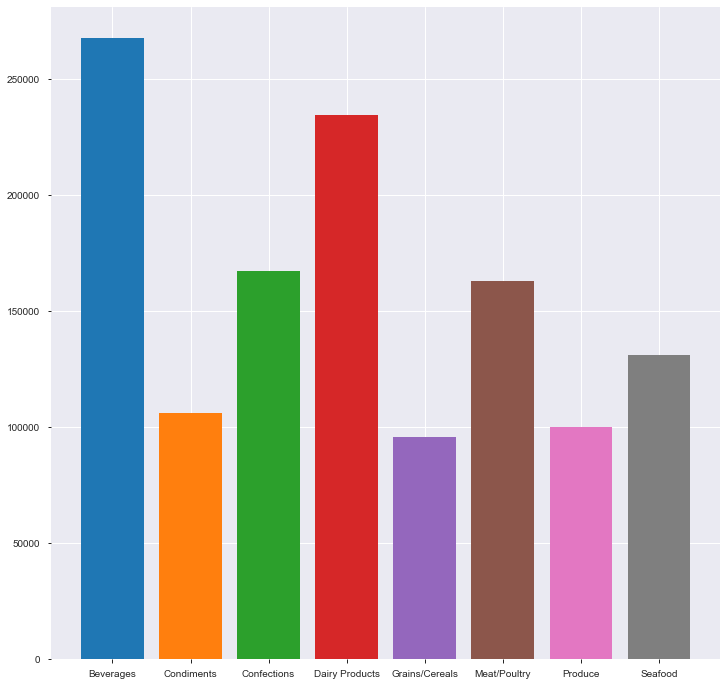

In [479]:
# plot order quantity totals by month
fig = plt.figure(figsize=(12,12))
for k,v in rev_per_cat.items():
    plt.bar(x=k, height=v)

In [ ]:
# What were the top 3 selling product categories in each region or country?
# What were the lowest 3 selling product categories in each region or country?